# A primer on the Finite Element Method

This notebook provides a demonstration of the Finite Element Method, a technique to obtain a numerical solution of a partial differential equation. This is by no means a complete introduction, but serves more as a numerical example of how the technique works in practice. For more detail on the mathematics behind it, there are numerous books and resources online; for open-source implementations, you can check out [FEniCS](https://fenicsproject.org/), [DUNE](https://www.dune-project.org/modules/dune-fem/), [deal.II](www.dealii.org) and many others.

## Description
We are looking for the solution to the partial differential equation 

$$-\Delta u=f$$ 

on a domain $\Omega$. Here, $\Delta$ is the Laplace operator and $f$ is a known function. We assume that on the boundary of our domain $\partial \Omega$, $u$ takes value $0$.

To find a numerical solution, we apply the finite element method (FEM). The starting point of this method is that instead of solving the equation in the form above, we solve a _weak form_, obtained by multiplying the equation with a _test function_ $\phi$ and integrate over the domain $\Omega$. After integration by parts, this results in the following problem:
Find $u$ such that for all test functions $\phi$ we have

$$\int_\Omega\nabla u\cdot \nabla\phi = \int_\Omega f \phi.$$

The mentioned test functions belong to a set of functions with a specific property (in this case, a Sobolev space). If we find a function $u$ such that our equation is satisfied for all those test functions, we have found a _weak solution_.

One of the differences between a weak and a regular (strong) solution, is that the weak solution does not require the same amount of 'smoothness'. In our case, the weak solution does not need to have a second derivative (while the strong one does). However, it's good to know a weak solution is a generalization of a strong solution, meaning that if a strong solution exists, it will be equal to the weak one.

In this notebook, we apply FEM to the one-dimensional example (where $\Delta u$ reduces to $u''$), and investigate how the grid influences the exactness of the solution.


We solve the Laplace equation on the domain $\Omega=[0,1]$. We leave the right hand side open to experiment with different functions. As boundary conditions, we prescribe $u(0) = u(1) = 0$.
To obtain a FEM approximation, we require the following steps.
1. Discretize the domain
2. Choose basis functions $\phi$
3. Compute stiffness matrix and mass vector
4. Solve the linear system


## 1. Discretize the domain
We discretize the domain by partitioning it into a grid with grid points $x_0,...,x_{n}$.
The patch between subsequent grid points is commonly referred to as an _element_. This puts the 'Element' in Finite Element Method. (The 'Finite' stems from the fact that we cannot choose infinitely small elements; they need to have a _finite_ size). For now, we keep the size of an element constant ($h$). In two dimensions an element commonly takes a triangular (or quadrilateral) shape, in three dimensions a tetrahedon. We are going to compute an approximation of the solution for each element.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Number of elements
n = 10
# Element size
h = 1./n
# Nodes
xs = np.linspace(0,1,n+1)
# Right hand side function (expressed as an anonymous function)
f = lambda x: 6*x - 2
# Using this function, we know the solution must be u=x**2 - x**3

## 2. Choose basis functions
Now that the domain $[0,1]$ is partioned in $n$ elements, we can fix our test functions.
Instead of looking at the entire set of test functions, we look at combinations of _basis functions_. Much like basis vectors in linear algebra, other test functions can be expressed as linear combinations of these basis functions.

By fixing a finite sized set of basis functions $\phi_i$, we can expand the weak form to a system of equations: for all $i=1,...,n-1$, find $u$ such that

$$\int_\Omega\nabla u\cdot \nabla\phi_i = \int f \phi_i$$

is satisfied.

In this example, we choose piecewise linear basis functions $\phi_i$, $1\leq i \leq n-1$, defined as

$$ \phi_i = \begin{cases}0 & \mbox{ if }x < x_{i-1}\\ \frac{x-x_{i-1}}{x_{i}-x_{i-1}}& \mbox{ if }x_{i-1} < x < x_{i}\\ \frac{x_{i+1}-x}{x_{i+1}-x_{i}}& \mbox{ if }x_{i} < x < x_{i+1}\\ 0 & \mbox{ if }x > x_{i+1}\end{cases}$$

In other words: within each element, the functions are linear. On their corresponding grid node they have value 1, on every other node they have value 0. For higher precision, people often choose higher-degree polynomials, like quadratic or qubic functions.

For $n=10$, they look like this ($i=4$ is highlighted). Note that we won't actually use the `phi`-variable in the FEM formulation, it just serves as an illustration.

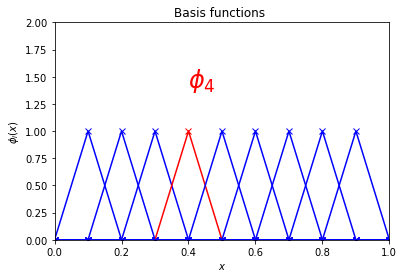

In [2]:
for i in range(1,n):
    phi=(np.zeros(xs.shape))
    phi[i] = 1
    if i==4:
        plt.plot(xs,phi,'r-x')
    else:
        plt.plot(xs,phi,'b-x')
plt.title(r'Basis functions ')
plt.text(4./n, 1.4, r'$\phi_4$', fontdict={'color':'red','size':24})
plt.xlabel(r'$x$')
plt.axis([0,1,0,2])
plt.ylabel(r'$\phi_i(x)$')
plt.show()
# First and last basis function are omitted, since we know the value of u in the first and last node.

## Compute the stiffness matrix and mass vector
Recall the weak form:

$$\int_\Omega\nabla u\cdot \nabla\phi = \int_\Omega f \phi.$$

We still have a fully continuous solution $u$. To discretize $u$, we use the assumption that we can express it in the very same basis functions: we will be looking for solutions of the form 

$$u = \sum_{j=1}^{n-1}\vec{u}_j\phi_j.$$

Since we establised basis functions earlier, we are essentally looking for the coefficient vector $\vec{u}$.
Substituting this in our system of equations gives us:
For all $i$, find $u_i$ such that 

$$\int_\Omega \sum_{j=1}^{n-1} u_j \nabla \phi_j\nabla\phi_i = \int_\Omega f \phi_i.$$

In the system above, all quantities except for $(u_i)_i$ are known; this can be expressed as a matrix-vector system:

$$A\vec{u} = \vec{b}$$

where matrix $A$ is defined as 

$$A_{ij} = \int_\Omega \nabla \phi_i\nabla\phi_j$$

and vector $\vec{b}$ is defined as 

$$\vec{b}_i= \int_\Omega f\phi_i.$$

$A$ is called the _stiffness matrix_, $\vec{b}$ is called the _load vector_. These terms refer to a classical case in engineering, where the finite element method is used to compute the strain on a beam for a given load.

Because the basis functions (and their derivatives) only overlap with their direct neighbours, the stiffness matrix is _sparse_, it contains many zero entries. This is convenient, since many solution algorithms can take advantage of that fact to find a solution much faster than in case of full matrices. We won't make use of that here.


### Stiffness matrix
We picked piecewise linear basis functions, so we evaluate piecewise constant gradients to compute $A$.
In our one-dimensional case, we obtain the following stiffness matrix:

$$A_{ij} = \int \nabla \phi_i\nabla\phi_j= \int_0^1 \phi_i'(x)\phi_j'(x)dx= \begin{cases}2/h & \mbox{ if } i=j\\-1/h& \mbox{ if } i = j\pm 1\\ 0 & \mbox{ else }\end{cases}$$


In [3]:
# Construct the tri-diagonal matrix
A = (np.diag(2*np.ones(n-1)) + np.diag(-np.ones(n-2),1) + np.diag(-np.ones(n-2),-1))/h
print("Stiffness matrix:\n",A)

Stiffness matrix:
 [[ 20. -10.   0.   0.   0.   0.   0.   0.   0.]
 [-10.  20. -10.   0.   0.   0.   0.   0.   0.]
 [  0. -10.  20. -10.   0.   0.   0.   0.   0.]
 [  0.   0. -10.  20. -10.   0.   0.   0.   0.]
 [  0.   0.   0. -10.  20. -10.   0.   0.   0.]
 [  0.   0.   0.   0. -10.  20. -10.   0.   0.]
 [  0.   0.   0.   0.   0. -10.  20. -10.   0.]
 [  0.   0.   0.   0.   0.   0. -10.  20. -10.]
 [  0.   0.   0.   0.   0.   0.   0. -10.  20.]]


### Load vector
While in this case it is possible to evaluate the expression for $\vec{b}$ exactly, for general $f$ or more complicated basis functions this is not the case. For our model problem, we choose a rough but consistent approximation, which happens to be exact in case $f$ is a linear function:

$$ \vec{b}_i= \int f\phi_i= \int_0^1 f(x) \phi_i(x)dx \approx hf\left(x_i\right).$$


In [4]:
# Construct the right hand side vector
# Centers of the elements
centers = xs[1:-1]
print("Element centers:",centers)
b = h*f(centers)
print("Load vector:",b)

Element centers: [ 0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9]
Load vector: [-0.14 -0.08 -0.02  0.04  0.1   0.16  0.22  0.28  0.34]


## Solve the system
Now that we have expressed our partial differential equation as a linear system, all that remains is to solve this system. Our system is quite small, but we note that for higher precision, the number of elements in the stiffness matrix increases drastically. In real life examples, the discretized domain can easily exceed a hundred thousand elements. For such large systems, people often have to resort to different solution methods. A popular class of algorithms is of the _iterative_ kind, where one repeats a sequence of steps, each time coming closer to the actual solution of the system. 

We have no such problems and we can solve our system simply by using Numpy's `linalg.solve` method.

In [5]:
# Solve linear system
u = np.linalg.solve(A,b)
print("Finite element solution: ",u)


Finite element solution:  [ 0.009  0.032  0.063  0.096  0.125  0.144  0.147  0.128  0.081]


The vector $\vec{u}$ contains the coefficients of the basis functions, which in this case correspond to the value of the approximate solution at any interior grid point $x_i$. We can plot the approximation and compare it with the exact solution.

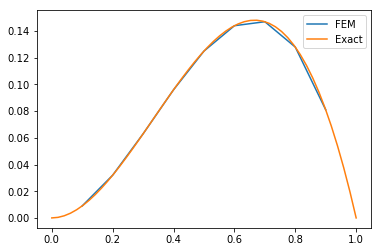

In [6]:
plt.plot(centers,u)
# As a comparison we plot the exact solution in the same graph
x = np.linspace(0,1)
u_exact = x**2 - x**3
plt.plot(x,u_exact)
l = plt.legend(['FEM','Exact'])

We see that even for low values of $n$, like $n=10$, the solution is reproduced exactly in each grid node, showing that this approximation by linear basis functions is, in some sense, the best approximation possible. The reason for this is that the load vector $\vec{b}$ is perfectly approximated; would $f$ have a higher degree, this exact approximation would not be guaranteed. 

In the general case, two ways to increase FEM accuracy are by

* Decreasing the element size
* Increasing the degree of the basis functions

You can try the first one yourself by adjusting the code. Just increase `n` to 100 or 1000 and you start seeing improvements. Increasing the polynomial order requires more tweaks: the stiffness matrix will get different coefficients. Normally, 

The FEM-implementations mentioned before have many high-degree basis functions readily available.

In the next notebook, we explore how to express and quantify the error between the approximation and the exact solution as a function of $n$ (or $h$, to be precise).